<h1 align="center">Tidying up LFP data from matlab cell array - tetX data</h1> 

In [15]:
!date

Wed Mar  9 12:48:03 PST 2022


___

## Manually define the following parameters:

#### Define matlab files to analyze

In [16]:
files = "raw_data/dlx*"

#### Define experiment condition (for figure titles)

In [17]:
condition = "tetX"

#### Define bird IDs

In [18]:
bird1 = "Or296"
bird2 = "B138"

#### Define maximum frequency. Power values for frequencies above freq_max will be discarded

In [19]:
freq_max = 500

#### Define start indeces of freq. ranges to sum, e.g. ranges 1-10, 11-100, and 101-end (manual log scale) power values for this hour
For the log scale, define the last slice to start at position 95 because frequencies 58-62 Hz will be removed due to American outlet noise and then frequency 101 Hz will be located at index 95.

In [20]:
freq_range = [0, 11, 96]

freq_range_label = ["1-10", "11-100", f"101-{freq_max}"]

#### Define number of morning hours

In [21]:
m_hours = 5

#### Define channels to be excluded because they are likely outside HVC

In [22]:
outside_HVC = [3, 7, 11, 15, 1, 5, 9, 13]

#### Define whether to keep only one channel or average across all channels
Excluding channels with broken electrodes and channels outside HVC.

In [23]:
# Define as "multi" or "single"
channels_used = "multi"

#### Make sure to define the days-to-dpi mapping and channels with broken electrodes to be removed below!

___

## Import packages

In [24]:
%load_ext blackcellmagic
%config InlineBackend.figure_format='retina'

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [25]:
import glob
import scipy.io as sio

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm

___

## Load data (cellarrays generated from raw data in matlab)

In [26]:
# Get all files to analyze
glob.glob(files)

['raw_data/dlx_07_07_00_00_morning_bulk_power.mat',
 'raw_data/dlx_06_12_06_15_evening_bulk_power.mat',
 'raw_data/dlx_06_16_00_00_morning_bulk_power.mat',
 'raw_data/dlx_05_30_06_10_evening_bulk_power.mat',
 'raw_data/dlx_05_12_05_13_morning_bulk_power.mat',
 'raw_data/dlx_06_30_00_00_evening_bulk_power.mat',
 'raw_data/dlx_09_09_00_00_morning_bulk_power.mat',
 'raw_data/dlx_05_15_05_23_evening_bulk_power.mat',
 'raw_data/dlx_05_02_05_11_morning_bulk_power.mat',
 'raw_data/dlx_05_30_06_10_morning_bulk_power.mat',
 'raw_data/dlx_05_12_05_13_evening_bulk_power.mat',
 'raw_data/dlx_05_02_05_11_evening_bulk_power.mat',
 'raw_data/dlx_09_09_00_00_evening_bulk_power.mat',
 'raw_data/dlx_06_30_00_00_morning_bulk_power.mat',
 'raw_data/dlx_05_15_05_23_morning_bulk_power.mat',
 'raw_data/dlx_06_16_00_00_evening_bulk_power.mat',
 'raw_data/dlx_07_07_00_00_evening_bulk_power.mat',
 'raw_data/dlx_06_12_06_15_morning_bulk_power.mat']

Raw power values are stored in tab 'evening_rec_chan_cell' and 'morning_rec_chan_cell' inside each mat file.

### !!! Files with 00_00 date do not include successive days and need custom day adjustment:
Date legend:  
06_16_00_00: 06/16, 06/18, 06/19, 06/20, 06/21, 06/22, 06/23, 06/24, 06/25, 06/27, and 06/28  
06_30_00_00: 06/30, 07/01, and 07/06  
07_07_00_00: 07/07, 07/08, 07/12, 07/13, 07/15, 07/19, 07/20, 07/21, 07/22, 07/26, 07/28, 08/02  
09_09_00_00: 09/09, 09/10, 09/11, 09/12, 09/16, 09/17, 09/18, 09/19

## Create a tidy data frame containing raw power values for morning and evening data
Note: The second, fourth and fifth array of each mat_contents file are empty and have no meaning. They are a side effect of the cellarray structure in matlab.

In [27]:
%%time
# Create empty lists to record data from all files
dates_all = []
recs_all = []
channels_all = []
hours_all = []
power_all = []
daytimes_all = []
freqs_all = []

# Define frequencies to be kept in final tidy dataframe (excluding freqs 58-62 Hz due to American outlet noise)
temp = np.arange(0,freq_max) + 1
freq_range_clean = np.concatenate([temp[:57], temp[62:freq_max]])

for file in glob.glob(files):
    # Add some space between print outs
    print(" ")
    
    # Load matlab file
    mat_contents = sio.loadmat(file)
    sub_folder = list(mat_contents.keys())[-1]
    # Get the date from the file name
    d = "-".join(["/".join(file.split("/")[-1].split("_")[1:3]), "/".join(file.split("/")[-1].split("_")[3:5])])
    # Get the daytime (morning or evening) from the file name
    daytime = file.split("/")[-1].split("_")[5]
    
    # Find number of days recorded
    n_recs = len(mat_contents[sub_folder])
    
    # Print some info about the data
    print("Date: ", d)
    print("Daytime: ", daytime)
    print("Filename: ", file)
    print("Subfolder: ", sub_folder)
    print("Days recorded: ", n_recs)
    
    # Create empty lists to record data from this day
    dates = []
    recs = []
    channels = []
    hours = []
    power = []
    daytimes = []
    freqs = []

    for rec in range(n_recs):
        # Find number of channels in this recording
        n_channels = len(mat_contents[sub_folder][rec][0])
        print(f"Channels in day {rec}: ", n_channels)
        
        # Only include days that were actually recorded and hence have > 1 channels
        if n_channels > 1:
            for channel in range(n_channels):
                # Find number of hours in this channel
                n_hours = len(mat_contents[sub_folder][rec][0][channel][0])  
                
                # Print number of hours if it is not 5 (expected value)
                if n_hours != 5:
                        print(f"Number of hours in day {rec}, channel {channel}: ", n_hours)

                for hour in range(n_hours):
                    # Print number of power values if it is not 800 (expected value)
                    if len(mat_contents[sub_folder][rec][0][channel][0][hour][0][0]) != 800:
                        print(f"Number of power values in day {rec}, channel {channel}, hour {hour}: ", len(mat_contents[sub_folder][rec][0][channel][0][hour][0][0]))
                    
                    # Get power values for frequencies 1 - freq_max, removing frequencies 58 - 62 (American outlet noise)
                    powers = np.concatenate([mat_contents[sub_folder][rec][0][channel][0][hour][0][0][:57], mat_contents[sub_folder][rec][0][channel][0][hour][0][0][62:freq_max]]) 
                    
                    ## Append the power values with their corresponding information to lists
                    power.append(powers)
                    dates.append([d,] * len(powers))
                    recs.append([[rec],] * len(powers))
                    # Add 1 to channel to correct for Python 0 indexing
                    channels.append([channel+1,] * len(powers))
                    hours.append([hour,] * len(powers))
                    daytimes.append([daytime,] * len(powers))
                    freqs.append(freq_range_clean)

    # Concatenate the lists                
    power = np.concatenate(power)
    dates = np.concatenate(dates)
    recs = np.concatenate(recs)
    channels = np.concatenate(channels)
    hours = np.concatenate(hours)
    daytimes = np.concatenate(daytimes)
    freqs = np.concatenate(freqs)  
    
    # Append the information from this day to the lists containing info from all files 
    dates_all.append(dates)
    recs_all.append(recs)
    channels_all.append(channels)
    hours_all.append(hours)
    power_all.append(power)
    daytimes_all.append(daytimes)
    freqs_all.append(freqs)

 
Date:  07/07-00/00
Daytime:  morning
Filename:  raw_data/dlx_07_07_00_00_morning_bulk_power.mat
Subfolder:  morning_rec_chan_cell
Days recorded:  12
Channels in day 0:  32
Channels in day 1:  32
Channels in day 2:  32
Channels in day 3:  32
Channels in day 4:  32
Channels in day 5:  32
Channels in day 6:  32
Channels in day 7:  32
Channels in day 8:  32
Channels in day 9:  32
Channels in day 10:  32
Channels in day 11:  32
 
Date:  06/12-06/15
Daytime:  evening
Filename:  raw_data/dlx_06_12_06_15_evening_bulk_power.mat
Subfolder:  evening_rec_chan_cell
Days recorded:  4
Channels in day 0:  32
Channels in day 1:  32
Channels in day 2:  32
Channels in day 3:  32
 
Date:  06/16-00/00
Daytime:  morning
Filename:  raw_data/dlx_06_16_00_00_morning_bulk_power.mat
Subfolder:  morning_rec_chan_cell
Days recorded:  11
Channels in day 0:  32
Channels in day 1:  32
Channels in day 2:  32
Channels in day 3:  32
Channels in day 4:  32
Channels in day 5:  32
Channels in day 6:  32
Channels in day 7

Create data frame from lists containing info from all files:

In [28]:
%%time
power_all = np.concatenate(power_all)
dates_all = np.concatenate(dates_all)
recs_all = np.concatenate(recs_all)
channels_all = np.concatenate(channels_all)
hours_all = np.concatenate(hours_all)
daytimes_all = np.concatenate(daytimes_all)
freqs_all = np.concatenate(freqs_all)

# Create data frame
df_orig = pd.DataFrame()
df_orig["date"] = dates_all
df_orig["daytime"] = daytimes_all
df_orig["day"] = recs_all
df_orig["channel"] = channels_all
df_orig["hour"] = hours_all
df_orig["freq"] = freqs_all
df_orig["power"] = power_all

CPU times: user 4.57 s, sys: 4.83 s, total: 9.41 s
Wall time: 10.7 s


In [29]:
# Add experiment condition to data frame
df_orig["condition"] = condition

df_orig

,date,daytime,day,channel,hour,freq,power,condition
0,07/07-00/00,morning,0,1,0,1,27282.257902,tetX
1,07/07-00/00,morning,0,1,0,2,33784.151644,tetX
2,07/07-00/00,morning,0,1,0,3,27270.325316,tetX
3,07/07-00/00,morning,0,1,0,4,22342.276140,tetX
4,07/07-00/00,morning,0,1,0,5,22143.722796,tetX
...,...,...,...,...,...,...,...,...
12196795,06/12-06/15,morning,3,32,4,496,17.101833,tetX
12196796,06/12-06/15,morning,3,32,4,497,17.979592,tetX
12196797,06/12-06/15,morning,3,32,4,498,19.044102,tetX
12196798,06/12-06/15,morning,3,32,4,499,20.614539,tetX


___

# Rename "hour" to represent morning (hours 0-4) and evening (hours 5-9)

In [30]:
df_orig["hour"].unique()

array([0, 1, 2, 3, 4])

In [31]:
# Add 5 to "hour" values where "daytime" = "evening"
df_orig.loc[df_orig["daytime"] == "evening", "hour"] += m_hours

# Show new hours
np.sort(df_orig["hour"].unique())

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## Drop the last hour of each morning and the last two hours of each evening recording in case the bird already started singing 
Morning: Drop the last hour, since the bird is more likely to sing in the first 4 hours.  
Evening: Only the first three hours are kept for each recording (these are hours 7,8,9 since the evening hours are labeled backwards).

In [32]:
for hour in [4, 5, 6]:
    df_orig = df_orig[df_orig.hour != hour]

# Show new hours
np.sort(df_orig["hour"].unique())

array([0, 1, 2, 3, 7, 8, 9])

___

# Split data from different birds

In [33]:
df_bird1 = df_orig.loc[df_orig["channel"] <= 16]
df_bird1["animal_ID"] = bird1

/var/folders/gd/8j_w3s656d1gkl7jfdnptqpc0000gq/T/ipykernel_11812/1710075169.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bird1["animal_ID"] = bird1


In [34]:
df_bird2 = df_orig.loc[df_orig["channel"] > 16]
df_bird2["animal_ID"] = bird2
# Substract 16 from channels of bird 2, since its channels were saved as 16-31 instead of 0-15
df_bird2["channel"] -= 16

/var/folders/gd/8j_w3s656d1gkl7jfdnptqpc0000gq/T/ipykernel_11812/2512377287.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bird2["animal_ID"] = bird2
/var/folders/gd/8j_w3s656d1gkl7jfdnptqpc0000gq/T/ipykernel_11812/2512377287.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bird2["channel"] -= 16


In [35]:
df_bird2.head()

,date,daytime,day,channel,hour,freq,power,condition,animal_ID
39600,07/07-00/00,morning,0,1,0,1,8399.772275,tetX,B138
39601,07/07-00/00,morning,0,1,0,2,14150.733882,tetX,B138
39602,07/07-00/00,morning,0,1,0,3,16637.905781,tetX,B138
39603,07/07-00/00,morning,0,1,0,4,16508.093739,tetX,B138
39604,07/07-00/00,morning,0,1,0,5,15450.748580,tetX,B138


___

# Fix the "day" column so days correctly reflect dpi (day post injection) for each bird

### !!! Files with 00_00 date do not include successive days and need custom day adjustment:
Date legend:  
06_16_00_00: 06/16, 06/18, 06/19, 06/20, 06/21, 06/22, 06/23, 06/24, 06/25, 06/27, and 06/28  
06_30_00_00: 06/30, 07/01, and 07/06  
07_07_00_00: 07/07, 07/08, 07/12, 07/13, 07/15, 07/19, 07/20, 07/21, 07/22, 07/26, 07/28, 08/02  
09_09_00_00: 09/09, 09/10, 09/11, 09/12, 09/16, 09/17, 09/18, 09/19

In [36]:
df_bird1["day"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [37]:
np.sort(df_bird1["date"].unique())

array(['05/02-05/11', '05/12-05/13', '05/15-05/23', '05/30-06/10',
       '06/12-06/15', '06/16-00/00', '06/30-00/00', '07/07-00/00',
       '09/09-00/00'], dtype=object)

In [38]:
# Add n days to "day" values based on date-day mapping (see csv file)
df_bird1.loc[df_bird1["date"] == "05/02-05/11", "day"] += 3
df_bird1.loc[df_bird1["date"] == "05/12-05/13", "day"] += 13
df_bird1.loc[df_bird1["date"] == "05/15-05/23", "day"] += 16
df_bird1.loc[df_bird1["date"] == "05/30-06/10", "day"] += 31
df_bird1.loc[df_bird1["date"] == "06/12-06/15", "day"] += 44

# Set dpi for files with non-consecutive days based on date-day mapping (see csv file)
# 06/16
df_bird1.loc[((df_bird1["date"] == "06/16-00/00") & (df_bird1["day"] == 0)), "day"] = 48 
# 06/18
df_bird1.loc[((df_bird1["date"] == "06/16-00/00") & (df_bird1["day"] == 1)), "day"] = 50 
# 06/19
df_bird1.loc[((df_bird1["date"] == "06/16-00/00") & (df_bird1["day"] == 2)), "day"] = 51 
# 06/20
df_bird1.loc[((df_bird1["date"] == "06/16-00/00") & (df_bird1["day"] == 3)), "day"] = 52 
# 06/21
df_bird1.loc[((df_bird1["date"] == "06/16-00/00") & (df_bird1["day"] == 4)), "day"] = 53
# 06/22
df_bird1.loc[((df_bird1["date"] == "06/16-00/00") & (df_bird1["day"] == 5)), "day"] = 54
# 06/23
df_bird1.loc[((df_bird1["date"] == "06/16-00/00") & (df_bird1["day"] == 6)), "day"] = 55
# 06/24
df_bird1.loc[((df_bird1["date"] == "06/16-00/00") & (df_bird1["day"] == 7)), "day"] = 56
# 06/25
df_bird1.loc[((df_bird1["date"] == "06/16-00/00") & (df_bird1["day"] == 8)), "day"] = 57
# 06/27
df_bird1.loc[((df_bird1["date"] == "06/16-00/00") & (df_bird1["day"] == 9)), "day"] = 59
# 06/28
df_bird1.loc[((df_bird1["date"] == "06/16-00/00") & (df_bird1["day"] == 10)), "day"] = 60

# 06/30
df_bird1.loc[((df_bird1["date"] == "06/30-00/00") & (df_bird1["day"] == 0)), "day"] = 62
# 07/01
df_bird1.loc[((df_bird1["date"] == "06/30-00/00") & (df_bird1["day"] == 1)), "day"] = 63
# 07/06
df_bird1.loc[((df_bird1["date"] == "06/30-00/00") & (df_bird1["day"] == 2)), "day"] = 68

# 07/07
df_bird1.loc[((df_bird1["date"] == "07/07-00/00") & (df_bird1["day"] == 0)), "day"] = 69
# 07/08
df_bird1.loc[((df_bird1["date"] == "07/07-00/00") & (df_bird1["day"] == 1)), "day"] = 70
# 07/12
df_bird1.loc[((df_bird1["date"] == "07/07-00/00") & (df_bird1["day"] == 2)), "day"] = 74
# 07/13 
df_bird1.loc[((df_bird1["date"] == "07/07-00/00") & (df_bird1["day"] == 3)), "day"] = 75
# 07/15 
df_bird1.loc[((df_bird1["date"] == "07/07-00/00") & (df_bird1["day"] == 4)), "day"] = 77
# 07/19
df_bird1.loc[((df_bird1["date"] == "07/07-00/00") & (df_bird1["day"] == 5)), "day"] = 81
# 07/20
df_bird1.loc[((df_bird1["date"] == "07/07-00/00") & (df_bird1["day"] == 6)), "day"] = 82
# 07/21
df_bird1.loc[((df_bird1["date"] == "07/07-00/00") & (df_bird1["day"] == 7)), "day"] = 83
# 07/22
df_bird1.loc[((df_bird1["date"] == "07/07-00/00") & (df_bird1["day"] == 8)), "day"] = 84
# 07/26
df_bird1.loc[((df_bird1["date"] == "07/07-00/00") & (df_bird1["day"] == 9)), "day"] = 88
# 07/28
df_bird1.loc[((df_bird1["date"] == "07/07-00/00") & (df_bird1["day"] == 10)), "day"] = 90
# 08/02 
df_bird1.loc[((df_bird1["date"] == "07/07-00/00") & (df_bird1["day"] == 11)), "day"] = 95

# 09/09
df_bird1.loc[((df_bird1["date"] == "09/09-00/00") & (df_bird1["day"] == 0)), "day"] = 133
# 09/10
df_bird1.loc[((df_bird1["date"] == "09/09-00/00") & (df_bird1["day"] == 1)), "day"] = 134
# 09/11
df_bird1.loc[((df_bird1["date"] == "09/09-00/00") & (df_bird1["day"] == 2)), "day"] = 135
# 09/12
df_bird1.loc[((df_bird1["date"] == "09/09-00/00") & (df_bird1["day"] == 3)), "day"] = 136
# 09/16
df_bird1.loc[((df_bird1["date"] == "09/09-00/00") & (df_bird1["day"] == 4)), "day"] = 140
# 09/17
df_bird1.loc[((df_bird1["date"] == "09/09-00/00") & (df_bird1["day"] == 5)), "day"] = 141
# 09/18
df_bird1.loc[((df_bird1["date"] == "09/09-00/00") & (df_bird1["day"] == 6)), "day"] = 142
# 09/19
df_bird1.loc[((df_bird1["date"] == "09/09-00/00") & (df_bird1["day"] == 7)), "day"] = 143

/Users/lauraluebbert/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [39]:
# Show dpis for bird 1
np.sort(df_bird1["day"].unique())

array([  3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  16,
        17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
        30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        44,  45,  46,  47,  48,  50,  51,  52,  53,  54,  55,  56,  57,
        59,  60,  62,  63,  68,  69,  70,  74,  75,  77,  81,  82,  83,
        84,  88,  90,  95, 133, 134, 135, 136, 140, 141, 142, 143])

#### Double-check that days were labeled correctly for bird 1:

In [40]:
days_collected_b1 = [3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,50,51,52,53,54,55,56,57,59,60,62,63,68,69,70,74,75,77,81,82,83,84,88,90,95,133,134,135,136,140,141,142,143]

# Raise error if collected days is not the same as days labeled in df
difference = set(np.sort(df_bird1["day"].unique())).symmetric_difference(set(days_collected_b1))
list_difference = list(difference)
if len(list_difference)>0:
    raise ValueError(f'Newly labeled days does not equal collected days for {bird1}. The following DPIs do not match: {list_difference}')
else:
    print(f'Newly labeled days equals collected days for {bird1}.')

Newly labeled days equals collected days for Or296.


### Same for bird 2:

In [41]:
# Add n days to "day" values based on date-day mapping (see csv file)
df_bird2.loc[df_bird2["date"] == "05/02-05/11", "day"] += 2
df_bird2.loc[df_bird2["date"] == "05/12-05/13", "day"] += 12
df_bird2.loc[df_bird2["date"] == "05/15-05/23", "day"] += 15
df_bird2.loc[df_bird2["date"] == "05/30-06/10", "day"] += 30
df_bird2.loc[df_bird2["date"] == "06/12-06/15", "day"] += 43

# Set dpi for files with non-consecutive days based on date-day mapping (see csv file)
# 06/16
df_bird2.loc[((df_bird2["date"] == "06/16-00/00") & (df_bird2["day"] == 0)), "day"] = 47 
# 06/18
df_bird2.loc[((df_bird2["date"] == "06/16-00/00") & (df_bird2["day"] == 1)), "day"] = 49 
# 06/19
df_bird2.loc[((df_bird2["date"] == "06/16-00/00") & (df_bird2["day"] == 2)), "day"] = 50 
# 06/20
df_bird2.loc[((df_bird2["date"] == "06/16-00/00") & (df_bird2["day"] == 3)), "day"] = 51 
# 06/21
df_bird2.loc[((df_bird2["date"] == "06/16-00/00") & (df_bird2["day"] == 4)), "day"] = 52
# 06/22
df_bird2.loc[((df_bird2["date"] == "06/16-00/00") & (df_bird2["day"] == 5)), "day"] = 53
# 06/23
df_bird2.loc[((df_bird2["date"] == "06/16-00/00") & (df_bird2["day"] == 6)), "day"] = 54
# 06/24
df_bird2.loc[((df_bird2["date"] == "06/16-00/00") & (df_bird2["day"] == 7)), "day"] = 55
# 06/25
df_bird2.loc[((df_bird2["date"] == "06/16-00/00") & (df_bird2["day"] == 8)), "day"] = 56
# 06/27
df_bird2.loc[((df_bird2["date"] == "06/16-00/00") & (df_bird2["day"] == 9)), "day"] = 58
# 06/28
df_bird2.loc[((df_bird2["date"] == "06/16-00/00") & (df_bird2["day"] == 10)), "day"] = 59

# 06/30
df_bird2.loc[((df_bird2["date"] == "06/30-00/00") & (df_bird2["day"] == 0)), "day"] = 61
# 07/01
df_bird2.loc[((df_bird2["date"] == "06/30-00/00") & (df_bird2["day"] == 1)), "day"] = 62
# 07/06
df_bird2.loc[((df_bird2["date"] == "06/30-00/00") & (df_bird2["day"] == 2)), "day"] = 67

# 07/07
df_bird2.loc[((df_bird2["date"] == "07/07-00/00") & (df_bird2["day"] == 0)), "day"] = 68
# 07/08
df_bird2.loc[((df_bird2["date"] == "07/07-00/00") & (df_bird2["day"] == 1)), "day"] = 69
# 07/12
df_bird2.loc[((df_bird2["date"] == "07/07-00/00") & (df_bird2["day"] == 2)), "day"] = 73
# 07/13 
df_bird2.loc[((df_bird2["date"] == "07/07-00/00") & (df_bird2["day"] == 3)), "day"] = 74
# 07/15 
df_bird2.loc[((df_bird2["date"] == "07/07-00/00") & (df_bird2["day"] == 4)), "day"] = 76
# 07/19
df_bird2.loc[((df_bird2["date"] == "07/07-00/00") & (df_bird2["day"] == 5)), "day"] = 80
# 07/20
df_bird2.loc[((df_bird2["date"] == "07/07-00/00") & (df_bird2["day"] == 6)), "day"] = 81
# 07/21
df_bird2.loc[((df_bird2["date"] == "07/07-00/00") & (df_bird2["day"] == 7)), "day"] = 82
# 07/22
df_bird2.loc[((df_bird2["date"] == "07/07-00/00") & (df_bird2["day"] == 8)), "day"] = 83
# 07/26
df_bird2.loc[((df_bird2["date"] == "07/07-00/00") & (df_bird2["day"] == 9)), "day"] = 87
# 07/28
df_bird2.loc[((df_bird2["date"] == "07/07-00/00") & (df_bird2["day"] == 10)), "day"] = 89
# 08/02 
df_bird2.loc[((df_bird2["date"] == "07/07-00/00") & (df_bird2["day"] == 11)), "day"] = 94

# 09/09
df_bird2.loc[((df_bird2["date"] == "09/09-00/00") & (df_bird2["day"] == 0)), "day"] = 132
# 09/10
df_bird2.loc[((df_bird2["date"] == "09/09-00/00") & (df_bird2["day"] == 1)), "day"] = 133
# 09/11
df_bird2.loc[((df_bird2["date"] == "09/09-00/00") & (df_bird2["day"] == 2)), "day"] = 134
# 09/12
df_bird2.loc[((df_bird2["date"] == "09/09-00/00") & (df_bird2["day"] == 3)), "day"] = 135
# 09/16
df_bird2.loc[((df_bird2["date"] == "09/09-00/00") & (df_bird2["day"] == 4)), "day"] = 139
# 09/17
df_bird2.loc[((df_bird2["date"] == "09/09-00/00") & (df_bird2["day"] == 5)), "day"] = 140
# 09/18
df_bird2.loc[((df_bird2["date"] == "09/09-00/00") & (df_bird2["day"] == 6)), "day"] = 141
# 09/19
df_bird2.loc[((df_bird2["date"] == "09/09-00/00") & (df_bird2["day"] == 7)), "day"] = 142

In [42]:
# Show dpis for bird 2
np.sort(df_bird2["day"].unique())

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        43,  44,  45,  46,  47,  49,  50,  51,  52,  53,  54,  55,  56,
        58,  59,  61,  62,  67,  68,  69,  73,  74,  76,  80,  81,  82,
        83,  87,  89,  94, 132, 133, 134, 135, 139, 140, 141, 142])

#### Double-check that days were labeled correctly for bird 2:

In [43]:
days_collected_b2 =[2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,43,44,45,46,47,49,50,51,52,53,54,55,56,58,59,61,62,67,68,69,73,74,76,80,81,82,83,87,89,94,132,133,134,135,139,140,141,142]

# Raise error if collected days is not the same as days labeled in df
difference = set(np.sort(df_bird2["day"].unique())).symmetric_difference(set(days_collected_b2))
list_difference = list(difference)
if len(list_difference)>0:
    raise ValueError(f'Newly labeled days does not equal collected days for {bird2}. The following DPIs do not match: {list_difference}')
else:
    print(f'Newly labeled days equals collected days for {bird2}.')

Newly labeled days equals collected days for B138.


___

# Remove broken electrode channels

Average over all days and hours:

In [44]:
# Bird 1
df_bird1_test = df_bird1.groupby(["daytime", "channel", "freq"])[["power"]].apply(np.mean)
df_bird1_test = df_bird1_test.reset_index()

# Bird 2
df_bird2_test = df_bird2.groupby(["daytime", "channel", "freq"])[["power"]].apply(np.mean)
df_bird2_test = df_bird2_test.reset_index()
df_bird2_test

,daytime,channel,freq,power
0,evening,1,1,17787.297246
1,evening,1,2,26532.830455
2,evening,1,3,26841.222901
3,evening,1,4,23359.270612
4,evening,1,5,19278.179821
...,...,...,...,...
15835,morning,16,496,19.041110
15836,morning,16,497,19.667388
15837,morning,16,498,20.985536
15838,morning,16,499,22.943037


Plot power values over frequency for each channel:

In [45]:
def plot_channels(temp_df, bird_ID):
    """
    Plots power values over frequency on a log scale for each channel.
    Morning and evening data are plotted separately.
    """
    
    fig, axs = plt.subplots(figsize=(20, 20), ncols=4, nrows=4)
    ax_col = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]
    ax_row = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]

    for channel, (ax_col, ax_row) in zip(temp_df["channel"].unique(), zip(ax_col, ax_row)):
        temp_df2 = temp_df.loc[temp_df["channel"] == channel]
        temp_df2 = temp_df2.groupby("daytime")

        ax = axs[ax_col, ax_row]

        for name, group in temp_df2:
            ax.plot(group["freq"], group["power"], label=name, marker='o', markersize=2, linestyle='', linewidth=2)

        ax.set(**{
            "xlabel": "Freq. (Hz)",
            "ylabel": "Power",
            "title": "{} {} - Channel {}".format(condition, bird_ID, channel)
        })

        # Change axes to log scale
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim(top=100000)

        # Add legend
        ax.legend()

    plt.tight_layout()        
    fig.show()

## Bird 1:

/var/folders/gd/8j_w3s656d1gkl7jfdnptqpc0000gq/T/ipykernel_11812/2944711502.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


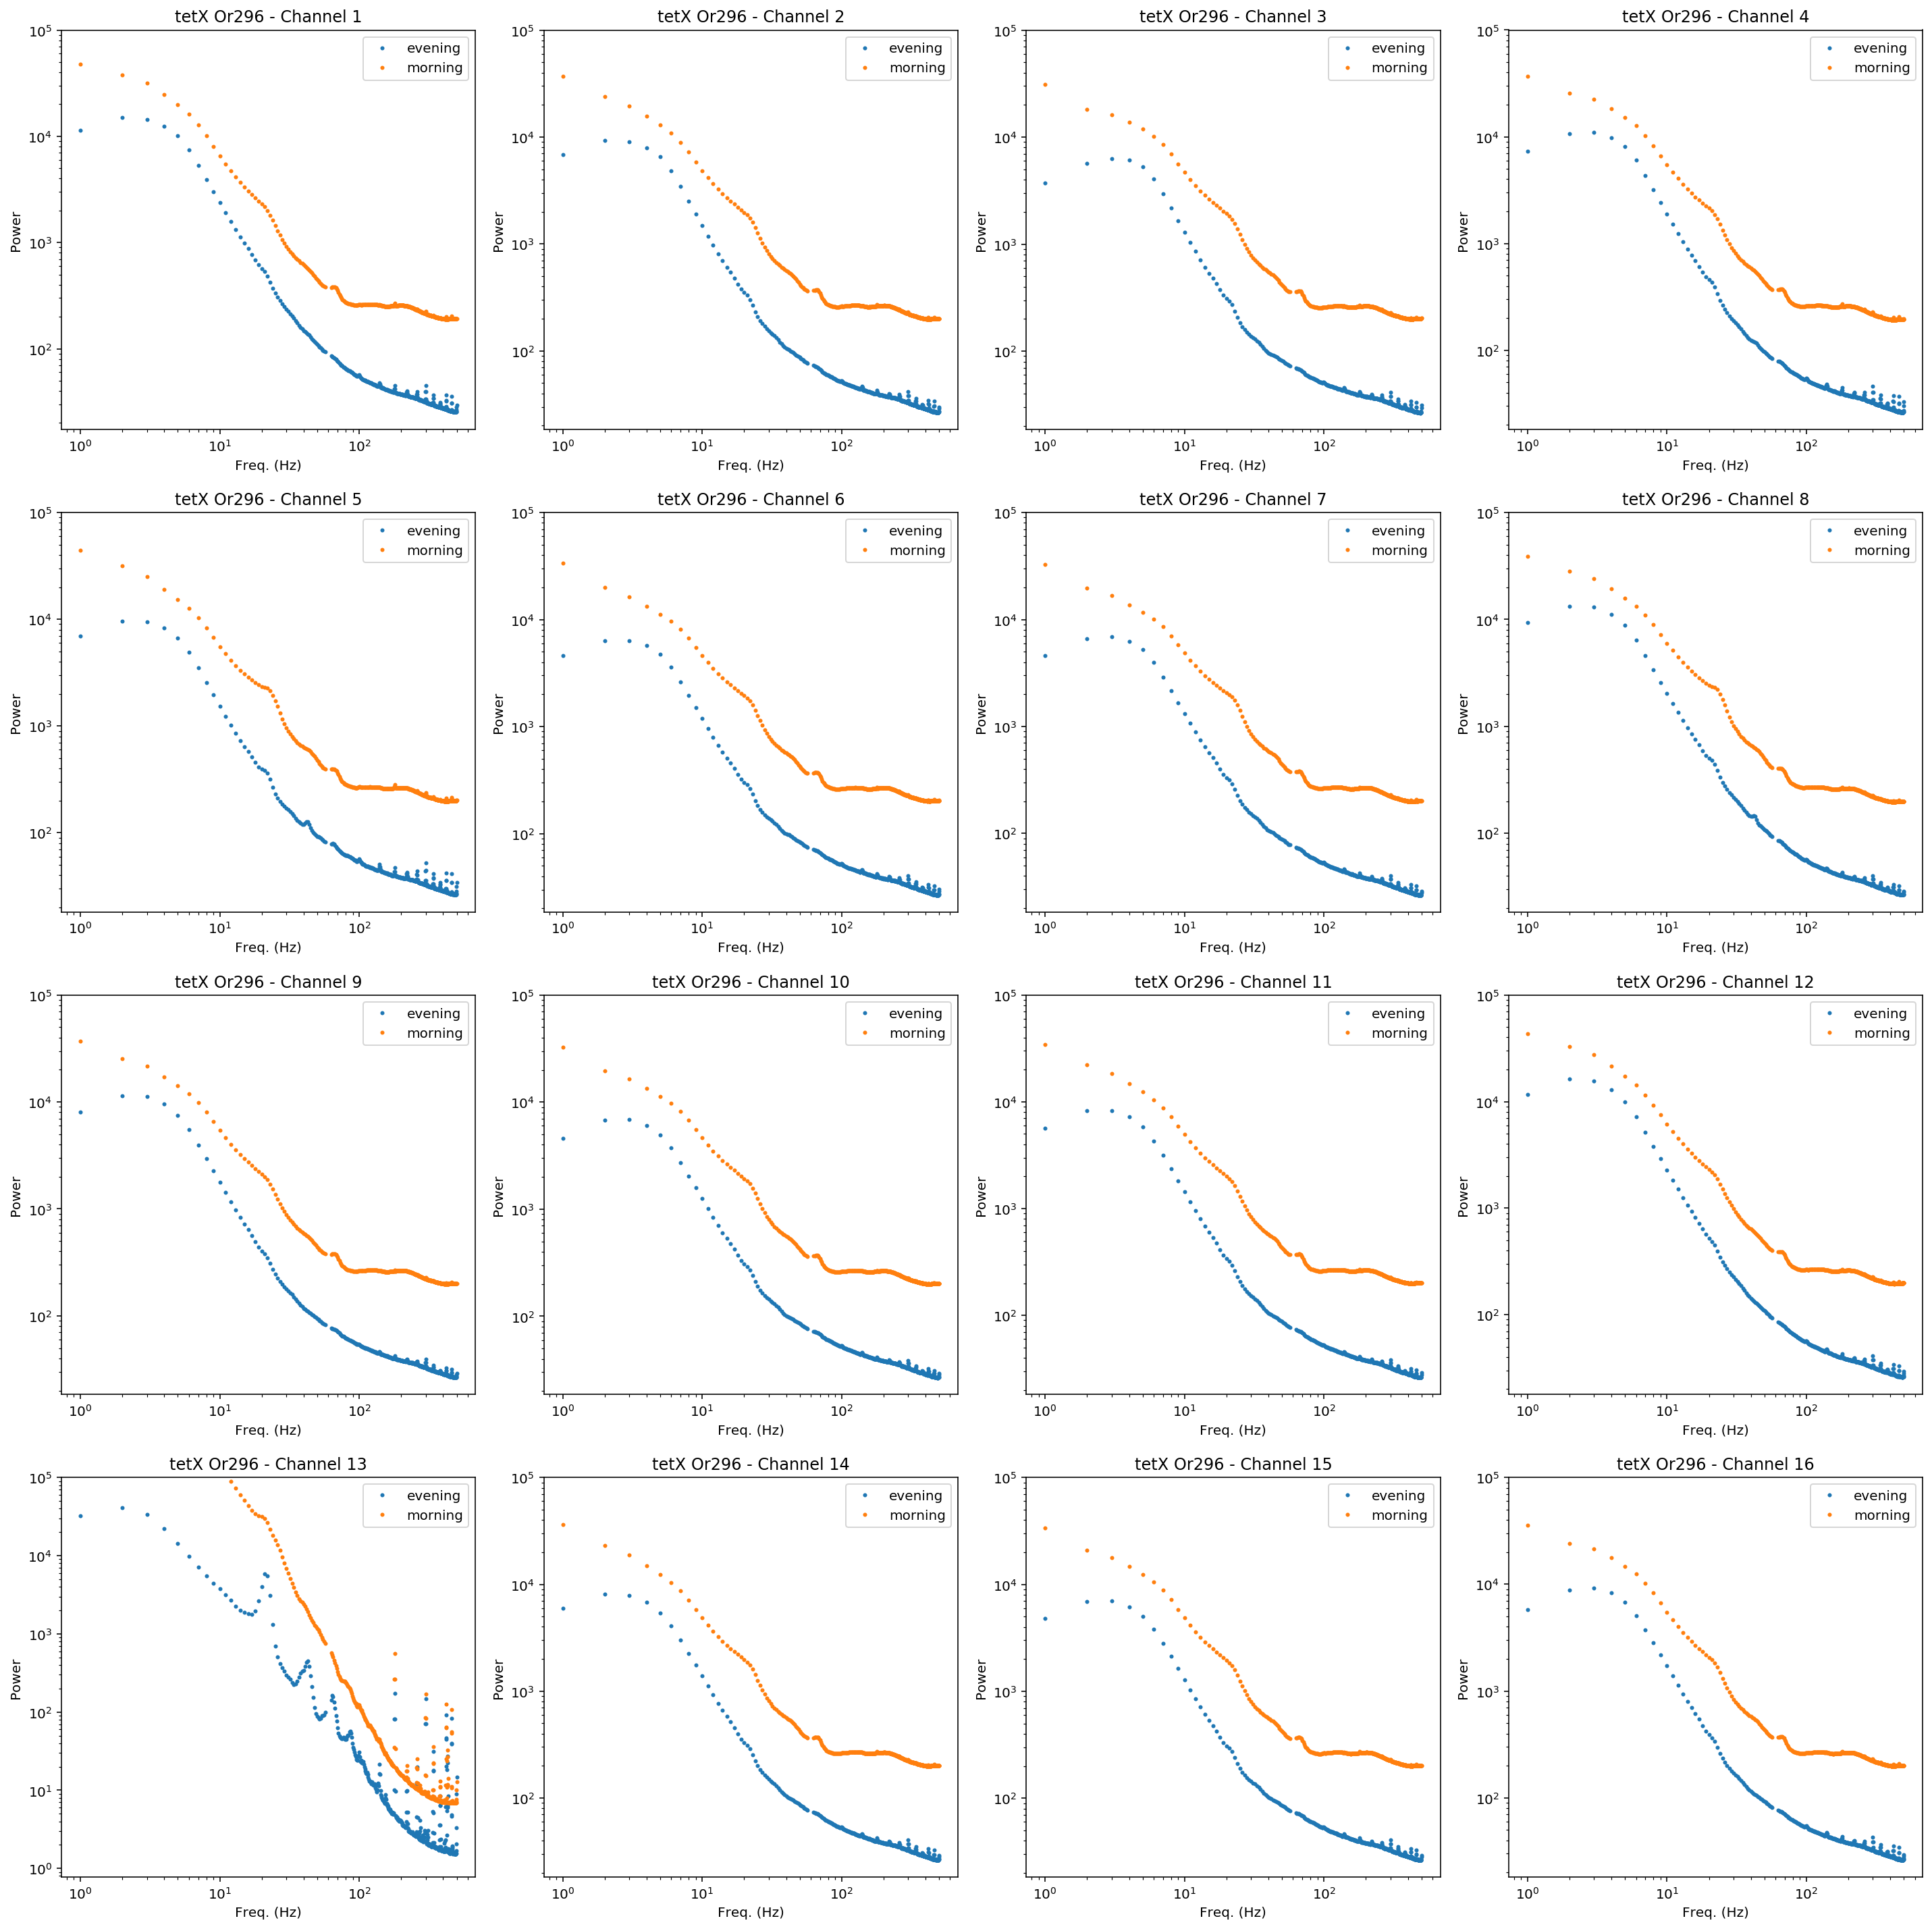

In [46]:
plot_channels(df_bird1_test, bird1)

#### !!! Manually define channels with broken electrodes to be removed from bird 1 data OR define single channel to keep

Note: Based on location of electrode array after brain dissection, we decide to keep channels 2, 4, 6, and 8 for Or296

In [47]:
# If averaging over multiple channels:
# Define channels with broken electrodes to remove (leave array empty if none)
bad_channels_b1 = [13,  9, 10, 12, 14, 16]

# If only keeping one single channel (ignored if channels_used == "multi"):
single_channel = 6

In [48]:
if channels_used == "single":
    bad_channels_b1 = df_bird1['channel'].unique()[df_bird1['channel'].unique() != single_channel]

In [49]:
for bad_channel in np.concatenate((bad_channels_b1, outside_HVC)):
    # Exclude bad channels and channels located outside HVC from test df (power values averaged across all days)
    df_bird1_test = df_bird1_test[df_bird1_test.channel != bad_channel]
    
    # Exclude bad channels and channels located outside HVC from original df
    df_bird1 = df_bird1[df_bird1.channel != bad_channel]

In [50]:
# Show new channel list
df_bird1['channel'].unique()

array([2, 4, 6, 8])

## Same for bird 2:

/var/folders/gd/8j_w3s656d1gkl7jfdnptqpc0000gq/T/ipykernel_11812/2944711502.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


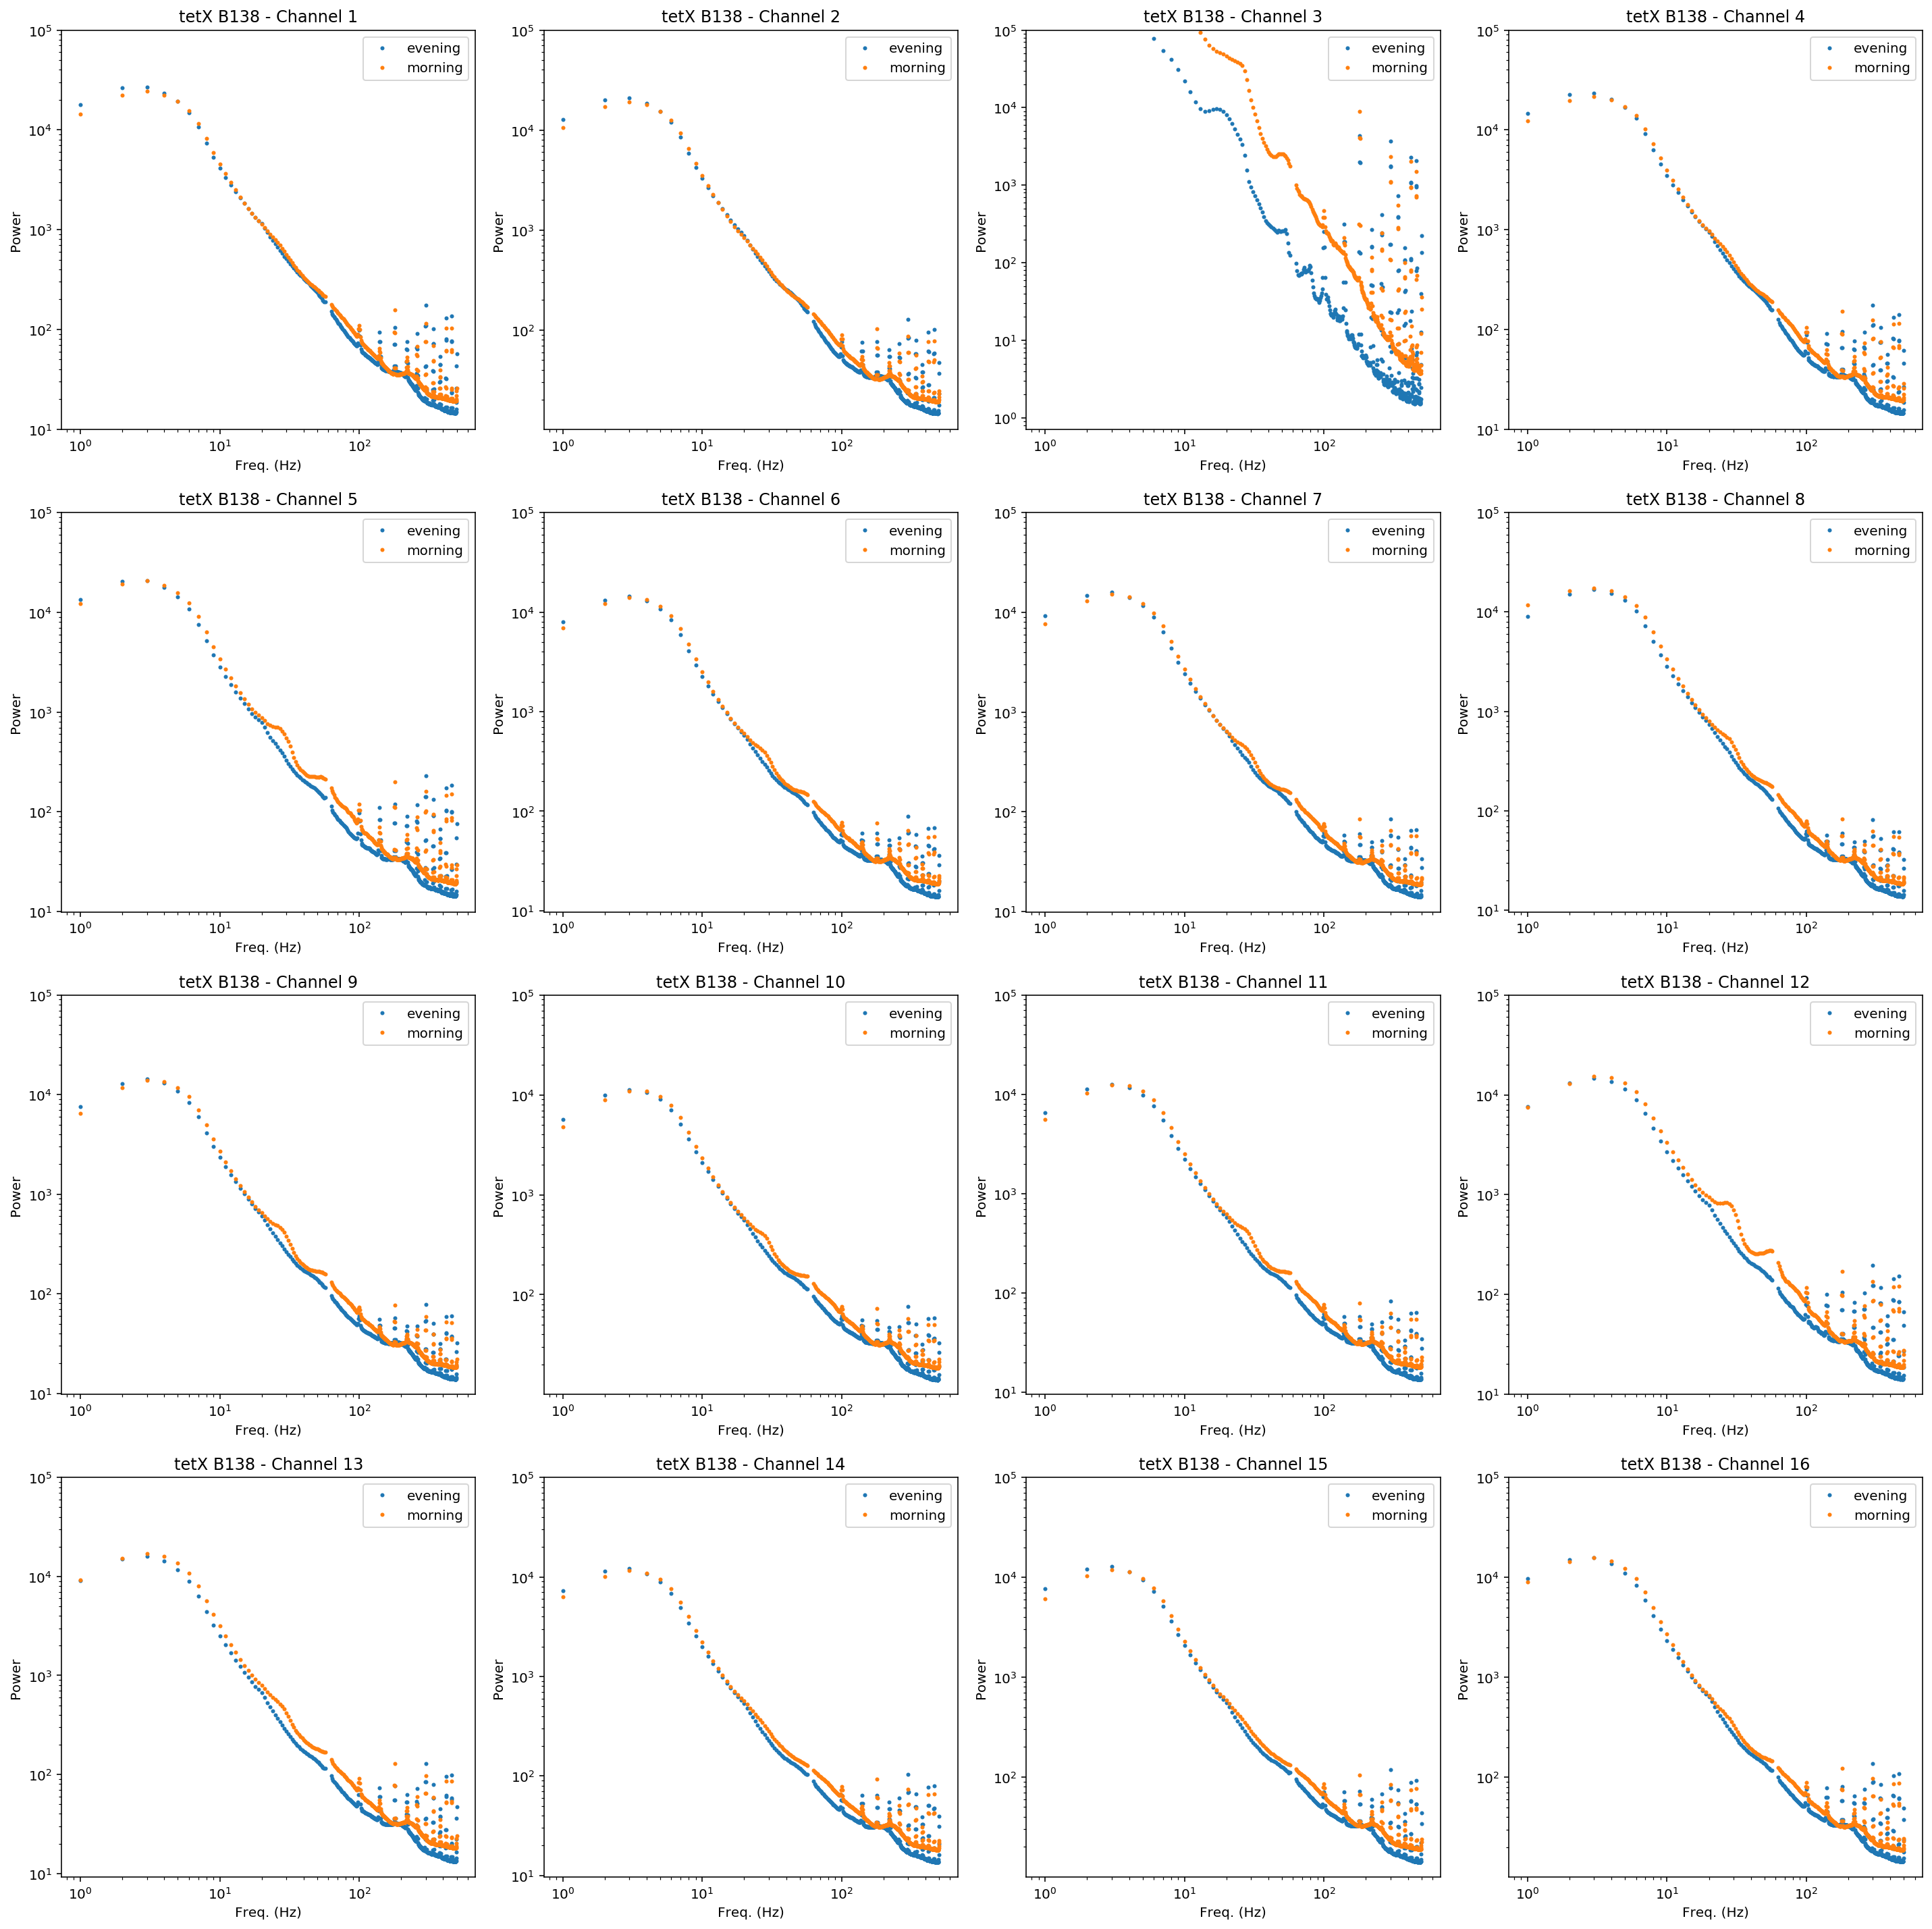

In [51]:
plot_channels(df_bird2_test, bird2)

#### !!! Manually define channels with broken electrodes to be removed from bird 2 data OR define single channel to keep

Note: Based on wavelet transform data during singing, we decide to keep channels 10, 11, 14 and 15 for B138.

In [52]:
# If averaging over multiple channels:
# Define channels with broken electrodes to remove (leave array empty if none)
bad_channels_b2 = [3,  2,  4,  6,  8, 9,  12, 16]

# If only keeping one single channel (ignored if channels_used == "multi"):
single_channel2 = 10

In [53]:
if channels_used == "single":
    bad_channels_b2 = df_bird2['channel'].unique()[df_bird2['channel'].unique() != single_channel2]

In [54]:
for bad_channel in np.concatenate((bad_channels_b2, outside_HVC)):
    # Keep channels 11 and 15, even though they are labeled as outside HVC
    if bad_channel == 11 or bad_channel == 15:
        continue
        
    else: 
        # Exclude bad channels and channels located outside HVC from test df (power values averaged across all days)
        df_bird2_test = df_bird2_test[df_bird2_test.channel != bad_channel]

        # Excluse bad channels and channels located outside HVC from original df
        df_bird2 = df_bird2[df_bird2.channel != bad_channel]

In [55]:
# Show new channel list
df_bird2["channel"].unique()

array([10, 11, 14, 15])

___

# Compare Power/Freq graph between animals by averaging across all channels

Average power values across all channels (excluding bad channels):

In [56]:
# Bird 1
df_bird1_test_2 = df_bird1_test.groupby(["daytime", "freq"])[["power"]].apply(np.mean)
df_bird1_test_2 = df_bird1_test_2.reset_index()

# Bird 2
df_bird2_test_2 = df_bird2_test.groupby(["daytime", "freq"])[["power"]].apply(np.mean)
df_bird2_test_2 = df_bird2_test_2.reset_index()

/var/folders/gd/8j_w3s656d1gkl7jfdnptqpc0000gq/T/ipykernel_11812/2452910435.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


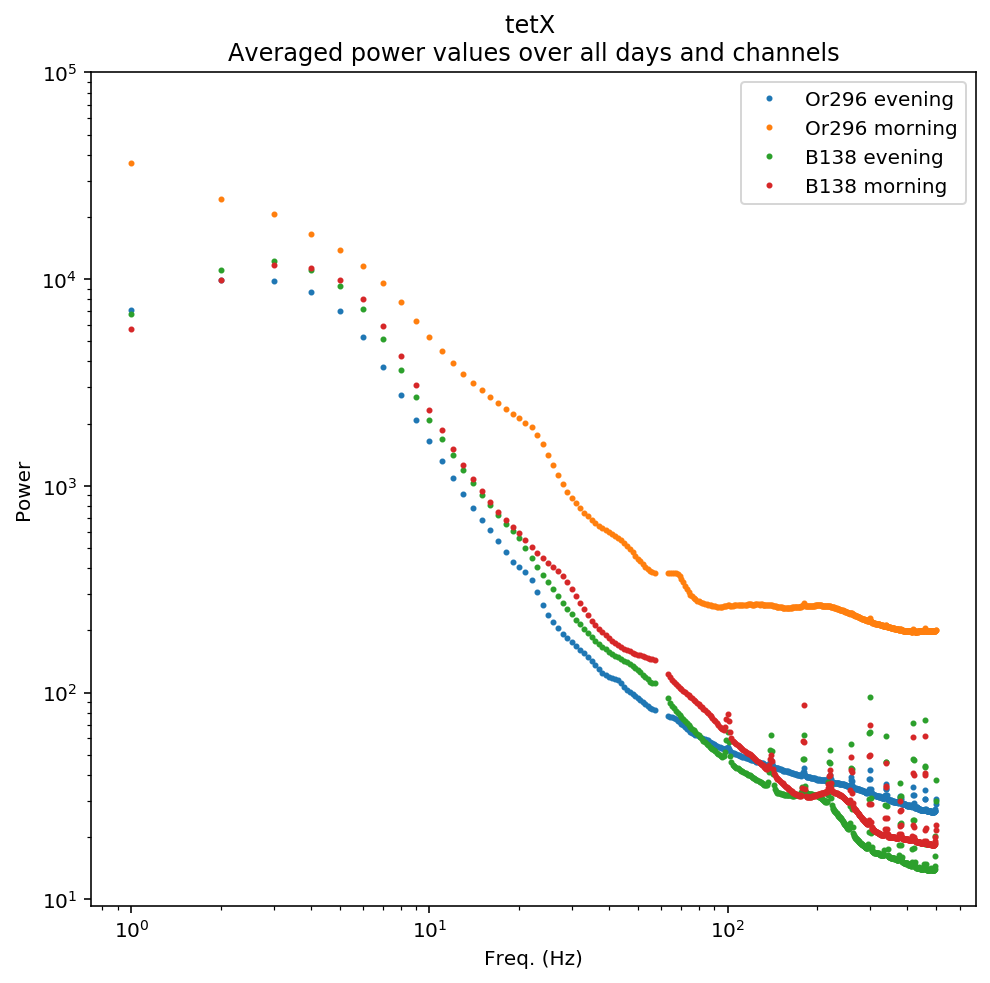

In [57]:
fig, ax = plt.subplots(figsize=(7, 7))

for name, group in df_bird1_test_2.groupby("daytime"):
    ax.plot(group["freq"], group["power"], label=f"{bird1} {name}", marker='o', markersize=2, linestyle='', linewidth=2)
    
for name, group in df_bird2_test_2.groupby("daytime"):
    ax.plot(group["freq"], group["power"], label=f"{bird2} {name}", marker='o', markersize=2, linestyle='', linewidth=2)

ax.set(**{
    "xlabel": "Freq. (Hz)",
    "ylabel": "Power",
    "title": "{} \nAveraged power values over all days and channels".format(condition)
})

# Change axes to log scale
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(top=100000)

# Add legend
ax.legend()
    
plt.tight_layout()    
fig.show()

___

# Add NaNs values to all days that do not have a recording for each bird

Supplement NaNs values to all days that do not have a recording for each bird. After this, each dataframe includes all days (0-143). (143 is last day recorded for any bird.)

In [58]:
# def add_NA(df_bird):
#     """
#     Add NA values to data frame for all days between 0 and 143 that are missing.
#     This function works for the data frames that still include power values for all frequencies.
#     """
#     freq_range_clean = df_bird["freq"].unique()

#     for daytime in df_bird["daytime"].unique():
#         # Get one daytime
#         df = df_bird[df_bird["daytime"] == daytime]
#         df_temp = pd.DataFrame()
        
#         # Find all days that are missing from data frame 
#         days_missing = np.array(list(set(df["day"].unique()) ^ set(np.arange(144))))

#         if len(days_missing) > 0:
#             # Add them to new dataframe, repeating each day as many times as there are frequencies
#             df_temp["day"] = np.repeat(days_missing, len(freq_range_clean))
#             # Add frequency values for each unique day
#             df_temp["freq"] = np.concatenate([freq_range_clean,] * len(days_missing))
#             # Add daytime
#             df_temp["daytime"] = daytime
#             # Add NA to power values
#             df_temp["power"] = np.nan

#             df_bird = pd.concat([df_bird, df_temp])
        
#     return df_bird

In [59]:
# # Show days before supplementing NaNs
# np.sort(df_bird1["day"].unique())

In [60]:
# df_bird1 = add_NA(df_bird1)
# df_bird2 = add_NA(df_bird2)

In [61]:
# # Show days after supplementing NaNs
# np.sort(df_bird1["day"].unique())

___

# !!! Drop power values for days 42 for Or296
Defined as outliers due to very high power across all frequencies or STD 100x higher than on other days.

In [62]:
df_bird1 = df_bird1[df_bird1.day != 42]

___

# Save clean data as csv

Sort, concatenate and save data frames as csv:

In [63]:
# Sort data frames by day, daytime and freq
df_bird1 = df_bird1.sort_values(["daytime", "day", "channel", "hour", "freq"])
df_bird2 = df_bird2.sort_values(["daytime", "day", "channel", "hour", "freq"])

# Add condition and animal ID
df_bird1["condition"] = condition
df_bird1["animal_ID"] = bird1
df_bird2["condition"] = condition
df_bird2["animal_ID"] = bird2

# Concatenate data frames from replicates
df_concat = pd.concat([df_bird1, df_bird2]) 

# Save as csv
if channels_used == "multi":
    df_concat.to_csv(f"{condition}_clean_multi-channel.csv", index=False)
    
if channels_used == "single":
    df_concat.to_csv(f"{condition}_clean_single-channel.csv", index=False)

Split csv into smaller files for saving on Github (since it is > 100 MB):

In [64]:
# Split data into files of 75 MB
!split -b 75m tetX_clean_multi-channel.csv tetX_clean_multi-channel_
# Delete original csv file
!rm tetX_clean_multi-channel.csv

Move split clean data files to designated folder:

In [ ]:
!mv tetX_clean_multi-channel_aa clean_data/tetX_clean_multi-channel_aa
!mv tetX_clean_multi-channel_ab clean_data/tetX_clean_multi-channel_ab